In [ ]:
# MIT License (https://opensource.org/licenses/MIT)
# Copyright 2020 Ryan Hausen and Brant Robertson

# Morpheus



This notebook can be run interactively in Google Colab
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/morpheus-project/morpheus/blob/master/examples/example_array.ipynb)

*note: if you're running in Colab, you can enable GPU/TPU acceleration, by going to: Edit->Notebook settings->Hardware accelerator*

## Table of contents
1. [Introduction](#introduction)
2. [Cataloging](#cataloging)
3. [Classifiying An Image](#classifying_an_image)
4. [Making A Segmentation Map](#making_a_segmentation_map)
4. [Colorizing A Morphological Classification](#colorizing_a_morphological_classification)

## Introduction <a name="introduction"></a>

This is a walkthrough for image classification using 
[Morpheus](https://github.com/morpheus-project/morpheus). Morpheus leverages a neural network 
to simultaneously perform source identification and 
morphological classification at the pixel level. The primary way to interact with Morpheus
is via the [Classifier](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier) 
class.

In [1]:
# if your running on Colab you need to install the package.

# 1) In the terminal, create a virtual environment
# $ mkdir ~/venv
# $ python3 -m venv ~/venv/morpheus-env
#
# 2) Activate the environment
# $ source ~/venv/morpheus-env/bin/activate
#
# 3) Install the packages
# $ pip install jupyter tensorflow morpheus-astro
#
# 4) Install an ipython kernel
# $ ipython kernel install --name morpheus-env --user
#
# 5) Save, shutdown, and logout by selecting File->Save all, Exit, and Log Out
#
# 6) Log back in, open the notebook, then activate the virtual environment using the cell below
!source ~/venv/morpheus-env/bin/activate

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from morpheus.classifier import Classifier
from morpheus.data import example

%matplotlib inline

## First get a sample image to examine.

This is a sample taken from GOODS which includes multiple sources with different morphologies.

In [4]:
h, j, v, z = example.get_sample()

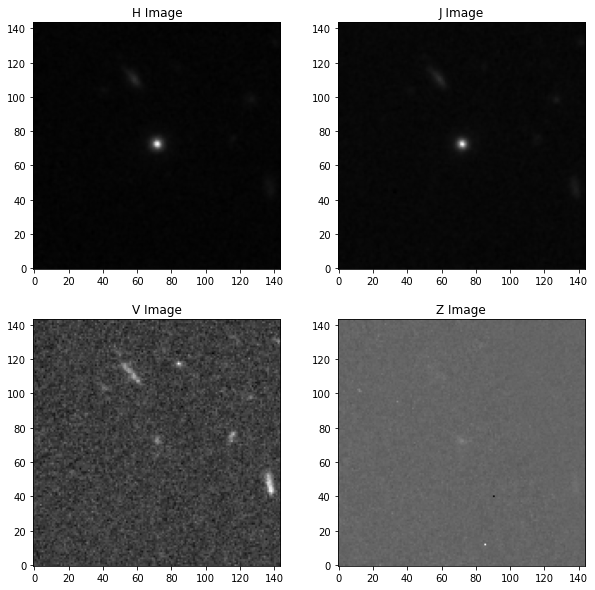

In [5]:
f, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
axes = np.array(axes).flatten()

for ax, arr, band in zip(axes, [h,j,v,z], 'HJVZ'):
    ax.set_title(f'{band} Image')
    ax.imshow(arr, origin='lower', cmap='gray')
plt.show()

## Classify Images <a name="classification"></a>

To classify an image, use [Classifer.classify](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.classify).
The arguments can be either a file path or a numpy array. The output is a dictionary that contains the
classifications as numpy arrays.

The output is a dictionary that contains a mapping for each pixel which represents the 
probability that a pixel belongs to one of the following classes:

- Spheroid
- Disk
- Irregular
- Point Source (Compact)
- Background

It also contains a mapping for `n`, which indicates how many times a classification was
recorded for that pixel

In [6]:
classified = Classifier.classify(h=h, j=j, v=v, z=z)

classifying:   0%|          | 0/11 [00:00<?, ?batch/s]/home/brantr/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/normalization.py:423: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  warnings.warn(
/home/brantr/.local/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/home/brantr/.local/lib/python3.8/site-packages/keras/legacy_tf_layers/convolutional.py:536: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is dep

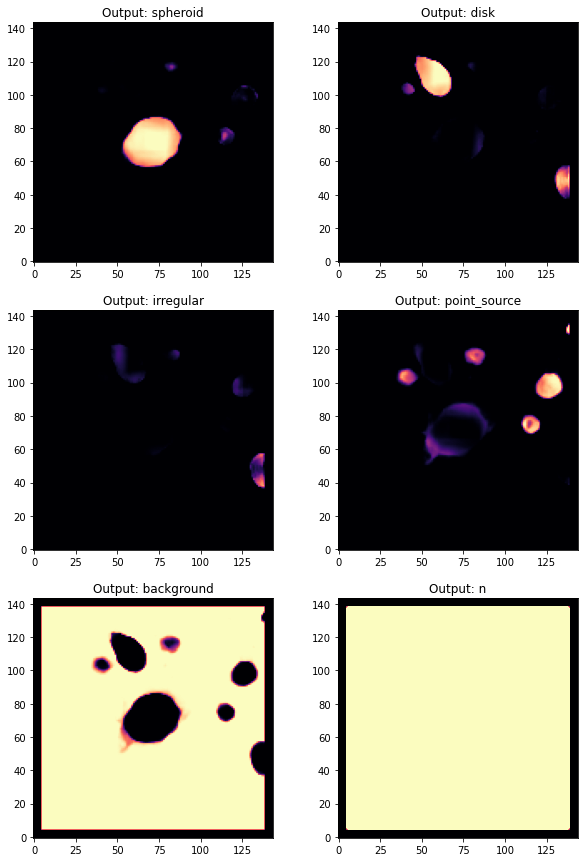

In [8]:
f, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
axes = np.array(axes).flatten()

for i, k in enumerate(classified):
    axes[i].set_title(f'Output: {k}')
    axes[i].imshow(classified[k], origin='lower', vmin=0, vmax=1, cmap='magma')
plt.show()

## Segmentation Map <a name="segmap"></a>

After an image has been classified, a segmap can be created using [Classifier.segmap_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.segmap_from_classifed).
For more information about the algorithm see the documentation for the function.

In [9]:
# the mask tells the segmentation mapping algorithm to ignore
# the areas unclassified as a result of the windowing classification
# method used.
mask = np.zeros_like(h, np.int)
mask[5:-5, 5:-5] = 1

segmap = Classifier.segmap_from_classified(classified, h, mask=mask)

Building Markers...
Watershedding...


/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0/lib/python3.8/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,

Deblending: 100%|██████████| 6/6 [00:00<00:00, 3930.32it/s]


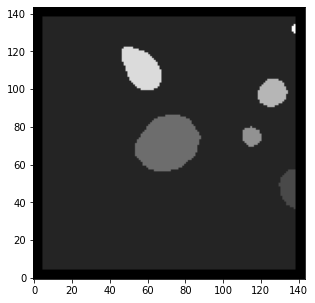

In [10]:
plt.figure(figsize=(5, 5))
plt.imshow(segmap, origin='lower', cmap='gray')
plt.show()

## Cataloging <a name="cataloging"></a>

Morpheus provides a cataloging functionality via [Classifier.catalog_from_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.catalog_from_classified)
for images that will return all of the detected sources and their morphological classifications.


In [11]:
catalog = Classifier.catalog_from_classified(classified, h, segmap)

In [12]:
print('Source ID\tLocation(y,x)\tMorphology:[Sph,Dsk,Irr,Ps]')
for source in catalog:
    _id = source['id']
    loc = source['location']
    morph = np.round(source['morphology'], decimals=2) # round for readability
    print('{}\t\t{}\t{}'.format(_id, loc, morph))


Source ID	Location(y,x)	Morphology:[Sph,Dsk,Irr,Ps]
1		[44, 138]	[0.   0.69 0.31 0.  ]
2		[72, 72]	[0.98 0.   0.   0.01]
3		[76, 116]	[0.26 0.   0.   0.73]
4		[98, 126]	[0.04 0.02 0.07 0.87]
5		[110, 58]	[0.   0.95 0.05 0.  ]
6		[131, 138]	[0. 0. 0. 1.]


## Colorizing A Morphological Classification <a name="colorizing_a_morphological_classification"></a>

Use [Classifier.colorize_classified](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified)  to make an RGB. The colors in the output have the following meanings:

- Red = Spheroid
- Blue = Disk
- Green = Irregular
- Yellow = Point Source (compact)
- Back = Background

Note when Morpheus doesn't output a strong classification for any one class they are colored white.

For more information on the coloring scheme see the [documentation](https://morpheus-astro.readthedocs.io/en/latest/source/morpheus.html#morpheus.classifier.Classifier.colorize_classified).


100%|██████████| 144/144 [00:00<00:00, 5598.63it/s]


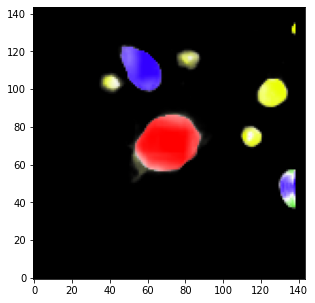

In [13]:
rgb = Classifier.colorize_classified(classified)
plt.figure(figsize=(5, 5))
plt.imshow(rgb, origin='lower')
plt.show()